**Note**: This tutorial is self-contained - you don't need to download any additional files. We assume you have working Pytorch environment and `robbytorch` installed (por. [how to install robbytorch](https://pypi.org/project/robbytorch/))

In [1]:
import os

# set the repo's root as the current working directory
while 'ipython' in os.getcwd():
    os.chdir("../")

# basic imports
import torch
import gc
import numpy as np
import pandas as pd
import seaborn as sns

# utility imports
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from collections import OrdedredDict

# logging
import mlflow
# from lib.consts import MLFLOW_TRACKING_URI

# import this library
import robbytorch as robby

# All references to 'cuda' will mean 'cuda:1' in this kernel.
# Remember to replace the device in every call to `torch.load` with `map_location='cuda'`.
torch.cuda.set_device(1)
device = torch.device("cuda") # cpu

sns.set_style('darkgrid')
%load_ext autoreload
%autoreload 2 # for hot reloading files
%matplotlib inline

In [2]:
WITH_MLFLOW = False
BATCH_SIZE = 32

In [3]:
# # if you have mlflow backend set-up, you can uncomment these lines:
# EXPERIMENT_NAME = "RobbyTutorial"
# MLFLOW_TRACKING_URI = "http://localhost:5001/"

# WITH_MLFLOW = True

# mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# mlflow.set_experiment(EXPERIMENT_NAME)

# Introduction

Our task is to classify certain images of animals and also predict their cuteness. For that we download Caltech101 dataset and consider subset of 5 labels. We also add a `cuteness` column. 

In [4]:
# Download Caltech101 dataset and extract metadata to pd.Dataframe
metadata, data_root = robby.tutorial.download_cute_dataset()

Files already downloaded and verified


In [5]:
# our task is to classify images and predict their cuteness. We'll learn both of these simultaneosuly.
summary = metadata.drop_duplicates(subset='label').sort_values(by='label')
CLASSES = list(summary['label_name'].values)
NUM_CLASSES = len(CLASSES)
summary

file_name label_name  label  cuteness
45   image_0001.jpg    lobster      0  0.108990
164  image_0001.jpg     beaver      1  0.257064
0    image_0001.jpg     pigeon      2  0.565173
86   image_0071.jpg      llama      3  0.794474
210  image_0001.jpg   hedgehog      4  0.807143

Create a train_test split of our data:

In [6]:
# splits dataframe into len(proportions) dataframes 
# returns a dict of Dataframes, i.e. train_test_split: Mapping[str, pd.Dataframe] 
train_test_split = robby.datasets.split_proportionally(metadata, by='label', proportions={"train": 0.7, "val": 0.3})

# Create a Dataset and Dataloaders

We need to subclass `robby.datasets.DictDateset` and implement two methods - for more info please read the docstring for that class.

In [7]:
class CuteDataset(robby.datasets.DictDataset):

    def load_data(self, idx):
        """should return a single dataitem"""
        record = self.metadata.iloc[idx]
        file_name = f"{record['label_name']}/{record['file_name']}"
        
        # use helper method from superclass to read the image
        return self.load_image(file_name)
    
    def load_target_dict(self, idx):
        """should return a dict of tensors and metadata"""
        record = self.metadata.iloc[idx].to_dict()
        
        ret = {}
        # here we'll store tensor targets
        ret['target'] = {col: torch.tensor(record[col]) 
            for col in ['label', 'cuteness']
        }
        # Pytorch is picky in terms of types. 
        # Also MSELoss requires 1-dimensional regression target, i.e tensor([3.14]), NOT tensor(3.14)
        ret['target']['cuteness'] = ret['target']['cuteness'].float().unsqueeze(0)
        
        # also add some metadata for convenience
        ret['label_name'] = record['label_name']
        
        return ret

Create datasets and dataloaders:

In [8]:
# create a basic transform
transform = transforms.Compose([
    # resise to size expected by our backbone net (por. below)
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

datasets = {
    k: CuteDataset(data_root, mdata, transform=transform) for k, mdata in train_test_split.items()
}
dataloaders = {
    k: DataLoader(ds, batch_size=BATCH_SIZE, shuffle=(k == 'train'), num_workers=2) for k, ds in datasets.items()
}

## Visualize Dataset

Now whenever you iter through the `dataloader` you get a structure with batched leaves:

In [9]:
dataitem = next(iter(dataloaders["train"]))

In [10]:
robby.show_structure(dataitem)

{'data': torch.Size([32, 3, 224, 224]),
 'target': {'label': torch.Size([32]), 'cuteness': torch.Size([32, 1])},
 'label_name': 32}

Use `robby.get_image_table` to visualize your data:

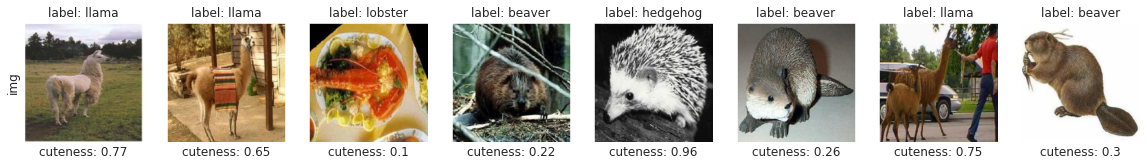

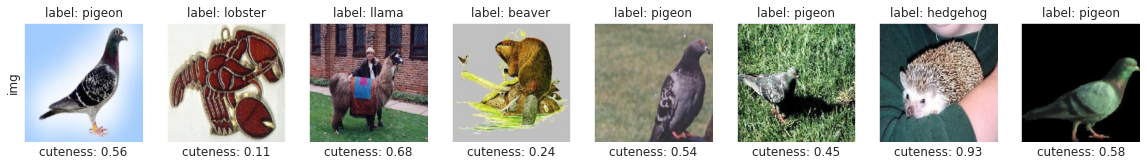

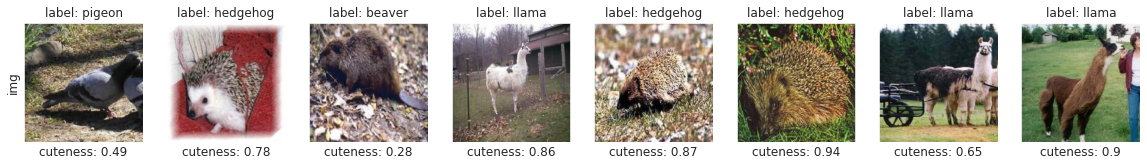

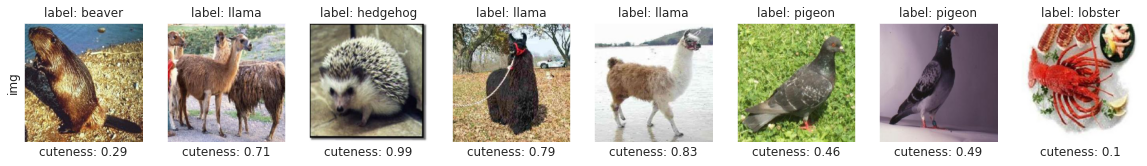

In [11]:
cols = 8
rows = min(BATCH_SIZE // cols, 4)

# You can double-click on the images to widen/shorten the outputs
for start, end in [(i*cols, (i+1)*cols) for i in range(rows)]:
    _ = robby.get_image_table(
            "label: ", dataitem['label_name'][start:end],
            "img", dataitem['data'][start:end],
            "cuteness: ", map(lambda t: str(round(t.item(), 2)), dataitem['target']['cuteness'][start:end])
)
robby.widen_outputs()

We can also show basic statistics of a tensor:

In [12]:
robby.summarize(dataitem["target"]['cuteness'])

# Create a model

`Robbytorch` allows us to load pretrained robust models from [microsoft/robust-models-transfer](https://github.com/Microsoft/robust-models-transfer) repository. Robust models have [cool properties](https://gradientscience.org/robust_reps/). We want to use the pretrained model as a backbone for a compound model in our downstream task.

In [13]:
def get_backbone(robust):
    if robust:
        # Load robustly pretrained model (on ImageNet) with eps=3 in L2.
        return robby.models.get_model_from_robustness("resnet18", pretraining='microsoft', eps=3.)
    
    return robby.models.get_model_from_robustness("resnet18", pretraining='pytorch')

As we want to optimize for two targets at the same time, we need a multi-headed layer on top of our backbone network.

In [14]:
class Hydra(nn.Module):
    
    def __init__(self, hidden_dim, num_classes):
        super().__init__()
        self.classifictaion_head = nn.Linear(hidden_dim, num_classes)
        self.regression_head = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        logits = self.classifictaion_head(x)
        regression = torch.sigmoid(self.regression_head(x))
        
        return logits, regression

Now we can define our model:

In [15]:
def get_model(robust=True):
    backbone = get_backbone(robust)
    
    # Replace last fully-connected layer with Identity for transfer learning
    latent_dim = backbone.fc.in_features # remember dim for later
    backbone.fc = torch.nn.Identity()
    
    return nn.Sequential(OrderedDict(
        # normalization from ImageNet 
        # (robust model was trained on that dataset so it makes sense to normalize inputs in the same way)
        normalization=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        backbone=backbone,
        head=Hydra(latent_dim, num_classes=NUM_CLASSES)
    ))

# Training

How can we train and evaluate such a strange model? With `Robbytorch` it's easy.



The main thing is to define custom function that takes `model`, batched `dataitem` returned by our dataloader and a `phase` which can be one of `['train', 'eval', 'train_eval']` - forward pass during train/evaluation phase (`'train'`/`'eval'` respectively) or evaluation on train data AFTER the model weights have been updated (`'train_eval'`). So the `'train'` phase defines the forward pass used for backpropagation, as it happens before the backward pass. Usually you'll ignore the `phase` parameter but it might be very usefull, see `Advanced Topics`. The function has to return a `dict` containing a `'loss'` key and any additional keys you want to log:

In [16]:
ce_crit = torch.nn.CrossEntropyLoss()
mse_crit = torch.nn.MSELoss()

# notice that here we don't use the `phase` parameter, i.e. we do the same exact thing in every phase.
def forward_hydra(model, dataitem, phase):
    # map all tensors in the structure to `robby.get_device(model)`
    dataitem = robby.structure_to(dataitem, model)
    
    data = dataitem["data"]
    # our Hydra head returns two tensors
    logits, reg = model(data)
        
    # compute both losses
    ce_loss = ce_crit(logits, dataitem["target"]["label"])
    mse_loss = mse_crit(reg, dataitem["target"]["cuteness"])
    
    acc = robby.get_accuracy(logits, dataitem["target"]["label"])
    
    return {
        # our main loss is the sum of both losses
        "loss": ce_loss + mse_loss, 
        "acc": acc, 
        # leading underscores mean that we don't want to log these 
        # - the default implementations of `robby.Writer` class will skip these keys
        "_classification_loss": ce_loss,
        "_reqression_loss": mse_loss
    }

One important thing to note here is that you can add any auxiliary losses to your main loss. If you'd like to add some regularization to the intermediate layers of your network, you could create `Callable` class and register it as a pytorch hook - for selected layers (i.e. use `Module#register_forward_hook` method). You could then gather intermediate loss inside of your hook and then sum all those losses inside the `forward_hydra` function (you can collect forward hooks by accessing `_forward_hooks` on a given module/layer and then access the desired attributes of your hook class). In this way you could collect all intermediate auxiliary losses and add them to your main loss. You could also use the `phase` param to zero-out those losses at the `'train_eval'` phase.

Now we're ready to construct `robby.Trainer` class for training our model!

In [17]:
trainer = robby.Trainer(
    train_loader=dataloaders["train"],
    val_loader=dataloaders["val"],
    forward=forward_hydra
)

Remember to put your model into your desired device before training!

In [18]:
model = get_model()

# move all parameters of the model to the selected device
_ = model.to(device)

We can run training with defualt params. Note that we log also the loss before updating model weights (`_before_update_loss`). It's useful to inspect both losses as large differences might mean that you need to reduce the learning rate. As you may see, the losses and their differences are indeed bad which implies that our default parameters for this task are bad (especially the learning rate is too large).

In [19]:
# you can also use profiler!
with robby.TreeProfiler(show_all=False):
    trainer.train_model(model)

WITH TREE_PROFILER:


Epoch: 10, VAL: 100%|██████████| 3/3 [00:00<00:00,  8.75it/s, loss=0.874]



  _     ._   __/__   _ _  _  _ _/_   Recorded: 09:57:30  Samples:  2238
 /_//_/// /_\ / //_// / //_'/ //     Duration: 9.338     CPU time: 6.410
/   _/                      v3.4.2

Program: /opt/anaconda/anaconda3/envs/robbytorch/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/portal/.local/share/jupyter/runtime/kernel-d04823ee-266f-4269-bc48-6e67da023ecd.json

9.338 <module>  <ipython-input-19-f2de7b31053d>:2
└─ 9.338 train_model  robbytorch/train.py:104
      [562 frames hidden]  robbytorch, tqdm, torch, multiprocess...
         9.157 _loop  robbytorch/train.py:63
         │  2.089 poll.poll  <built-in>:0
         ├─ 2.478 forward_hydra  <ipython-input-16-8f46d4cea78b>:5
         │  ├─ 1.225 _call_impl  torch/nn/modules/module.py:866
         │  │     [179 frames hidden]  torch, robbytorch, <built-in>, torchv...
         │  ├─ 0.743 get_accuracy  robbytorch/utils.py:220
         │  │     [8 frames hidden]  robbytorch, <built-in>
         │  └─ 0.509 structure_to  robbytor

# Customize training

### Custom writers

As you can see, running training with default values is not very informative. However `Trainer#train_model` accepts a list of `robby.Writers` as an argument. We'll use 3 usefull writers. Keep in mind that it's easy to add your own custom `Writer` - all it takes is to implement class with a `log_metrics` method.

In [20]:
def get_writers(save_path = "ipython/trained_models/temp"):
    writers = [
        # prints some nice charts during traning 
        robby.writers.LiveLossWriter(),
        # saves model during training
        robby.writers.ModelWriter(
            save_path=save_path,
            log_per=20
        )
    ]
    
    # You can also add MLFlowWriter if you have your MLFlow backend set-up
    if WITH_MLFLOW:
        writers.append(
            robby.writers.MLFlowWriter(
                run_name="yet_another_run",
                params={}, # logs this as mlflow.log_params(params)
                log_per=5
            )
        )
        
    return writers

### Custom optimizer & scheduler

We create optimizer and scheduler specs - for more details read `robby.train.get_optimizer` docstring.

There are 2 main reasons to create specs instead of entire objects:
- generally optimizer should be created AFTER model has been moved to CUDA, so it's good idea to postpone the creation of the actual class
- it's way more convenient for logging

In [21]:
# https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer
optimizer_spec = dict(
        id="Adam",
        filter_requires_grad=True, # filters out all params that don't require grad (weight decay could otherwise affect them)
        params={
            ".backbone": dict(lr=1e-5), # parameter group for backbone submodule
            ".head.classifictaion_head": dict(lr=1e-4), # you can access nested submodules
            ".head.regression_head": dict(lr=1e-3)
        },
        weight_decay=0.01 # default params for all groups
    )

scheduler_spec = dict(
    id="StepLR",
    step_size=20, 
    gamma=0.7
)

### Train again, but with custom params!

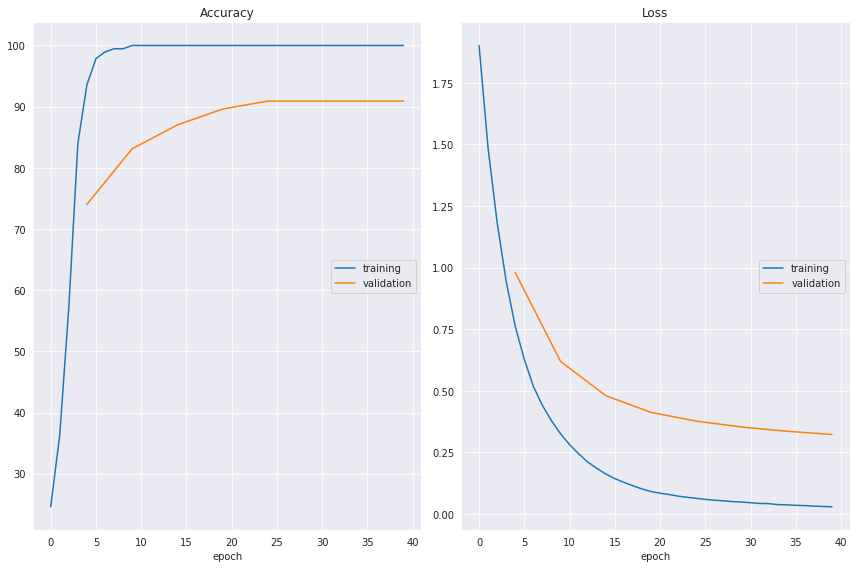

Accuracy
	training         	 (min:   24.599, max:  100.000, cur:  100.000)
	validation       	 (min:   74.026, max:   90.909, cur:   90.909)
Loss
	training         	 (min:    0.030, max:    1.901, cur:    0.030)
	validation       	 (min:    0.323, max:    0.980, cur:    0.323)


In [22]:
model = get_model().to(device)
writers = get_writers() # generally it's safer to keep reference to these, por. Note below.

trainer.train_model(
    model=model,
    optimizer=optimizer_spec,
    scheduler=scheduler_spec,
    epochs=40,
    eval_per=5,
    writers=writers,
    eval_before_training=True
)

**Note**: if your notebook's output breaks, you can still redraw the above plots. You'll have to keep reference to the `writers` array, then select the instance `w` of `robby.writers.LiveLossWriter` and call `w.liveloss.draw()`.

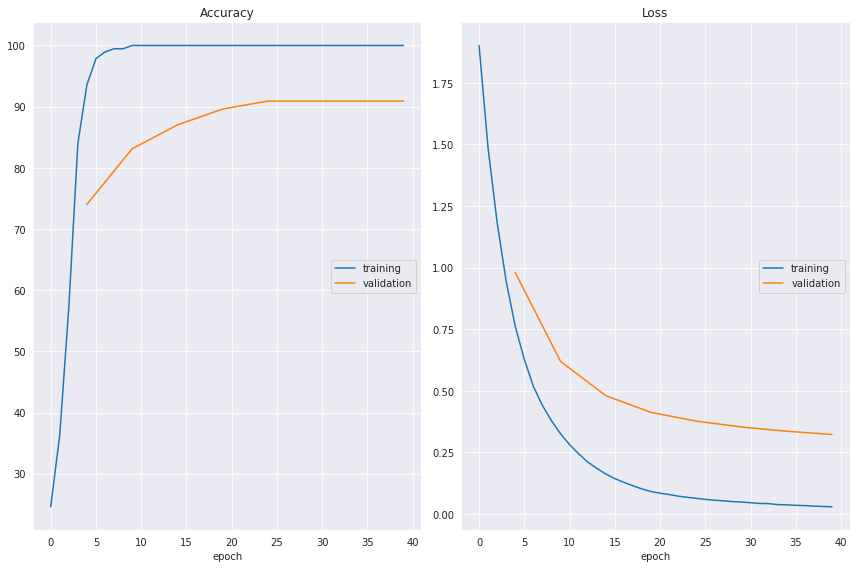

Accuracy
	training         	 (min:   24.599, max:  100.000, cur:  100.000)
	validation       	 (min:   74.026, max:   90.909, cur:   90.909)
Loss
	training         	 (min:    0.030, max:    1.901, cur:    0.030)
	validation       	 (min:    0.323, max:    0.980, cur:    0.323)


In [23]:
w = next(w for w in writers if isinstance(w, robby.writers.LiveLossWriter))
w.liveloss.draw()

You can once again evaluate your model on a selected loader:

In [24]:
trainer.eval_loop(model, dataloaders['val'])

Epoch: -, VAL: 100%|██████████| 3/3 [00:00<00:00,  9.41it/s, loss=0.323]


{'loss': <robbytorch.utils.AverageMeter at 0x7f3985bcd110>,
 'acc': <robbytorch.utils.AverageMeter at 0x7f39fca51e50>,
 '_classification_loss': <robbytorch.utils.AverageMeter at 0x7f39f90cb450>,
 '_reqression_loss': <robbytorch.utils.AverageMeter at 0x7f39f90cbcd0>}

# Advanced topics

## Augmenting data dynamically during train loop

`robby.Trainer` accepts additional parameters:
- `augment_data` - `Callable` called during train/eval phase before `forward` - you can use this as a hook to add additional keys to `dataitem` returned by `dataloaders`; Same signature as `forward` but the `phase` argument has just two values: `'train'` or `'eval'`;
- `loss_key` - string that specifies which key in the dict returned by the `forward` should be considered as a `loss`. Default: `'loss'`.

## Example: Robust training

First lets create adversarial examples for our model. We used robust model so let's take a big epsilon.

In [25]:
# Perform a PGD attack on inputs from dataitem, maximize the loss, i.e. try to fool the model
# Note that here we maximize the combined loss defined in the `forward_hydra` function
# You can also define another `forward_` function that returns only classification/regression loss
advs = robby.input_transforms.PGD(
    model, dataitem, forward_hydra, eps=80, step_size=20, Nsteps=60, use_tqdm=True, minimize=False)

Loss: 17.752649307250977: 100%|██████████| 60/60 [00:05<00:00, 10.75it/s]


We can see that our accuracy dropped significantly:

In [26]:
# dataitem was on CPU - it's important for visualization, the code breaks if you want to show images on GPU.
logits, cuteness = model(dataitem["data"].to(device))
adv_logits, adv_cuteness = model(robby.tensor_to(advs, model)) # you could as well write `advs.to(device)`
# but this one is better if you're unsure of what device your model is on

acc = robby.get_accuracy(logits, dataitem["target"]["label"].to(device))
adv_acc = robby.get_accuracy(adv_logits, dataitem["target"]["label"].to(device))

acc, adv_acc

(100.0, 0.0)

Lets visualize the adversarial examples:

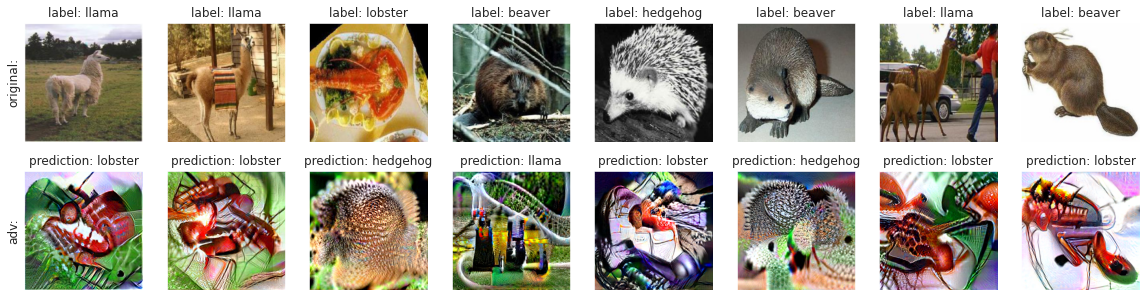

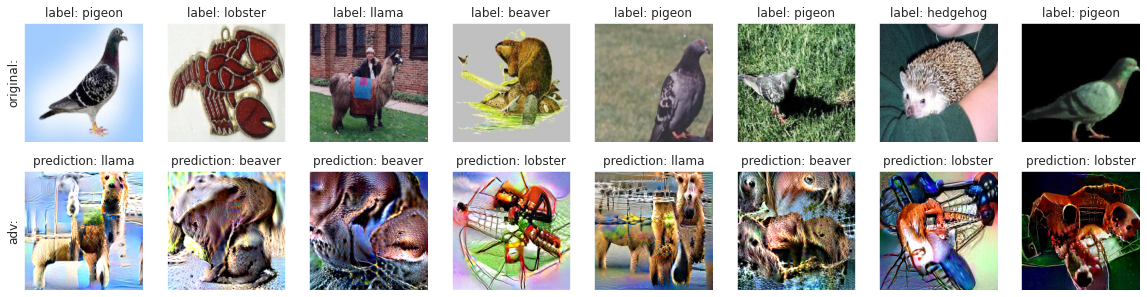

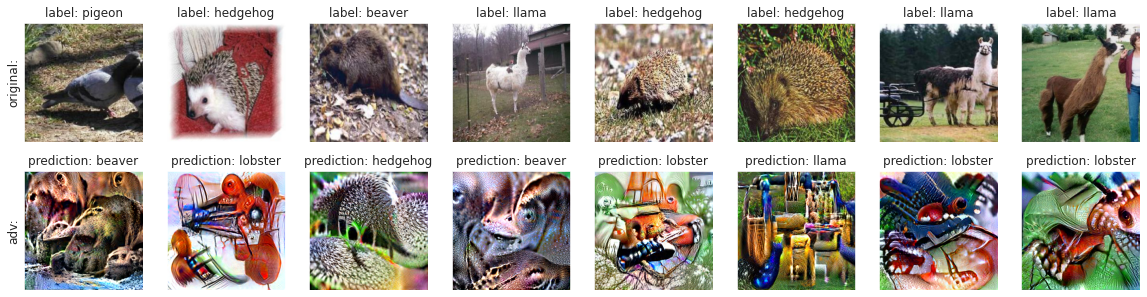

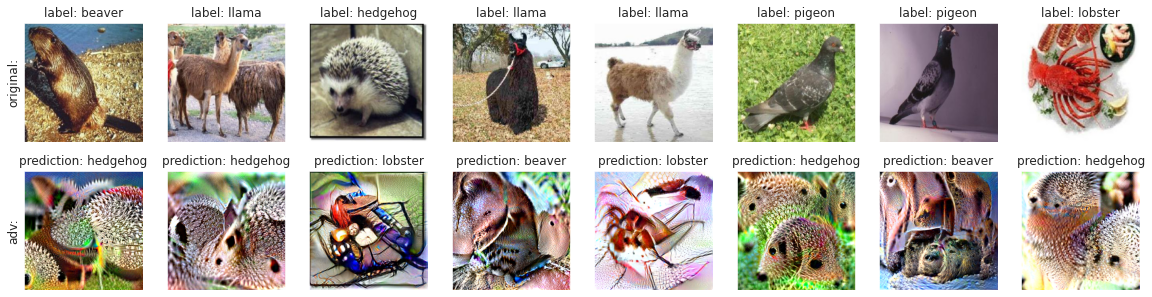

In [27]:
cols = 8
rows = min(BATCH_SIZE // cols, 4)

# You can double-click on the images to widen/shorten the outputs
for start, end in [(i*cols, (i+1)*cols) for i in range(rows)]:
    _ = robby.get_image_table(
            "label: ", dataitem['label_name'][start:end],
            "original:", dataitem['data'][start:end],
            "prediction: ", adv_logits[start:end].argmax(dim=1),
            "adv:", advs[start:end],
            classes=CLASSES # converts lists of ints (targets) to lists of labels
)
robby.widen_outputs()

### Adding `augment_data` callback

Let's create some data augmentation. We will add some adversarial examples to every batched `dataitem` - with smaller `eps`, as we want the examples to be indistinguishable from the original images by the naked eye.

In [28]:
def add_adv_data(model, dataitem, phase):
    advs = robby.input_transforms.PGD(
        # specify loss_key as '_classification_loss` to attack only the classification head
        model, dataitem, forward_hydra, loss_key='_classification_loss',
            eps=1.25, step_size=0.5, Nsteps=20, use_tqdm=False, minimize=False)
    
    return {**dataitem, "adv_data": advs}

From now on the `forward` callback of `robby.Trainer` will receive augmented `dataitem` dict. We can take advantage of that and define custom `forward` function for robust training:

In [29]:
def forward_adv(model, dataitem, phase):
    # overwrite the "data" key - we train/eval our model on adv_data
    adv_res = forward_hydra(model, {**dataitem, 'data': dataitem["adv_data"]}, phase)
    
    # compute std params for reference, but don't track the gradients
    with torch.no_grad():
        res = forward_hydra(model, dataitem, phase)
    
    return {
        "adv_loss": adv_res["loss"],
        "adv_acc": adv_res["acc"],
        "std_loss": res["loss"],
        "std_acc": res["acc"]
    }

Now let's create an instance of `robby.Trainer` that will perform robust training:

In [30]:
adv_trainer = trainer.clone(
    augment_data=add_adv_data,
    forward=forward_adv,
    loss_key='adv_loss' # IMPORTANT! Thanks to this we will do robust training
)

Keep in mind that robust training takes considerably more time as we need to compute adversarial examples for every batch!

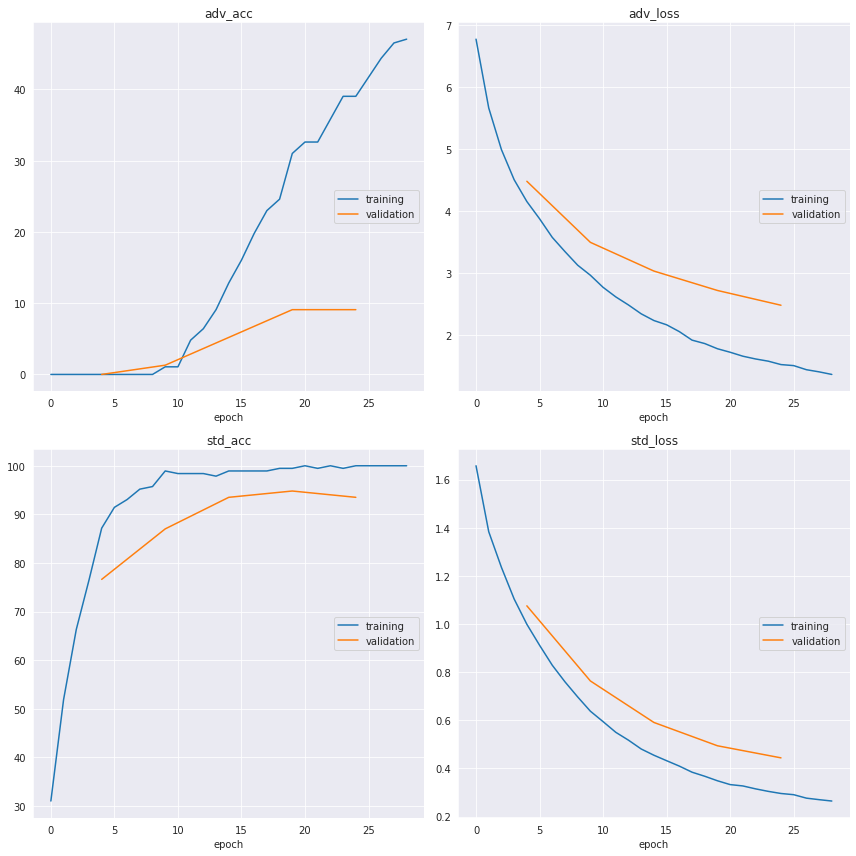

adv_acc
	training         	 (min:    0.000, max:   47.059, cur:   47.059)
	validation       	 (min:    0.000, max:    9.091, cur:    9.091)
adv_loss
	training         	 (min:    1.370, max:    6.770, cur:    1.370)
	validation       	 (min:    2.484, max:    4.481, cur:    2.484)
std_acc
	training         	 (min:   31.016, max:  100.000, cur:  100.000)
	validation       	 (min:   76.623, max:   94.805, cur:   93.506)
std_loss
	training         	 (min:    0.264, max:    1.658, cur:    0.264)
	validation       	 (min:    0.444, max:    1.076, cur:    0.444)


Epoch: 30, VAL:  33%|███▎      | 1/3 [00:02<00:04,  2.19s/it, loss=2.13]

In [ ]:
# let's start from non-robust model to show that robust training works!
model = get_model(robust=False).to(device)

adv_trainer.train_model(
    model=model,
    optimizer=optimizer_spec,
    scheduler=scheduler_spec,
    epochs=40,
    eval_per=5,
    writers=get_writers(),
    eval_before_training=True
)

It takes quite a long time. However robust models preserve robustness during transfer learning, therefore to save time we can skip robust data augmentation and evaluation during train phase:

In [ ]:
def add_adv_data_eval(model, dataitem, phase):
    if phase == 'eval':
        return add_adv_data(model, dataitem, phase)
    
    return dataitem

def forward_adv_eval(model, dataitem, phase):
    if phase == 'eval':
        return forward_adv(model, dataitem, phase)
        
    res = forward_hydra(model, dataitem, phase)
    
    return {
        # we don't return adv_ keys during train/train_eval phases
        "std_loss": res["loss"],
        "std_acc": res["acc"]
    }

adv_eval_trainer = trainer.clone(
    augment_data=add_adv_data_eval,
    forward=forward_adv_eval,
    loss_key='std_loss'
)

model = get_model().to(device)

adv_eval_trainer.train_model(
    model=model,
    optimizer=optimizer_spec,
    scheduler=scheduler_spec,
    epochs=40,
    eval_per=5,
    writers=get_writers(),
    eval_before_training=True
)

## Visualizations and model interpretations

Robust models have interpretable gradients which let's us retrive some human-aligned features and understand what the model is really relying on.

In [ ]:
def get_forward_explain(target: int=None, mult: float=None):
    def forward_explain(model, dataitem, phase):
        dataitem = robby.structure_to(dataitem, model)
        logits, reg = model(dataitem["data"])

        loss = 0.
        # modify the targets
        if mult is not None:
            loss += mse_crit(reg, mult * dataitem["target"]["cuteness"])
        if target is not None:
            loss += ce_crit(logits, target * torch.ones_like(dataitem["target"]["label"]))

        return {"loss": loss}
    return forward_explain

`robby.explain` prints images modified toward minimization/maximization of value under "loss" key returned by the `fd`. We can move the images closer to or further away from the selected `label` or `cuteness` value.

In [ ]:
def explain(model, dataitem, target=None, mult=None, rows=4, minimize=True, eps=80, step_size=20, Nsteps=60):
    fd = get_forward_explain(target=target, mult=mult)

    robby.explain(model, dataitem, fd, cols=8, rows=rows, classes=CLASSES, labels=dataitem['target']['label'],
           eps=eps, step_size=step_size, Nsteps=Nsteps, use_tqdm=True, minimize=minimize)

In [ ]:
dataitem = next(iter(dataloaders["train"]))
CLASSES

In [ ]:
explain(model, dataitem, mult=0, rows=2) # reduce cuteness

In [ ]:
explain(model, dataitem, mult=1.5, rows=2) # increase cuteness by 1.5

In [ ]:
explain(model, dataitem, target=2, mult=1.5, rows=2) # increase cuteness by 1.5 and also move closer to 'pigeon'

In [ ]:
explain(model, dataitem, target=2, mult=0, rows=2) # move closer to pigeon but try to reduce cuteness to 0

# Utilities

In [ ]:
# Clean-up interruped tqdm instances and garbage-collect CUDA cache.
robby.clean()

In [ ]:
# print memory summary of given CUDA device
print(robby.memory_summary('cuda:1'))